In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import os
src_path = '/Users/caritsang/Project/1d_AMR/src'

if src_path not in sys.path:
    sys.path.append(src_path)

import numpy as np
import matplotlib.pyplot as plt

In [3]:
import misc
import problem
import viz
import grid
from tqdm import tqdm

In [10]:
# Physical Parameters
gamma = 1.4  # Specific heat ratio for air

# Computational Domain
L  = 1  # Length of the domain (meters)
N  = 100    # Number of cells
dx = L / N  # Cell width
x  = np.linspace(0.5*dx, L - 0.5*dx, N)  # Cell centers

# Time-Stepping Parameters
CFL     = 0.5  # Courant number
t_final = 0.25  # Final time (seconds)
t       = 0.0   # Initial time

temporal = 'RK2'

# Initialize Conserved Variables [rho, rho*u, E]
U = np.zeros((N, 3))

# Initial Conditions
rho0 = np.where(x < 0.5, 1.0, 0.125)          # Density
u0   = np.zeros(N)                            # Velocity
p0   = np.where(x < 0.5, 1.0, 0.1)            # Pressure
E0   = p0 / (gamma - 1) + 0.5 * rho0 * u0**2  # Total Energy

U[:, 0] = rho0       # Density
U[:, 1] = rho0 * u0  # Momentum
U[:, 2] = E0         # Energy

# Function to convert conserved to primitive variables
def cons_to_prim(U):
    rho = U[...,0]
    u   = U[...,1] / rho
    E   = U[...,2]
    p   = (gamma - 1) * (E - 0.5 * rho * u**2)
    return rho, u, p

# HLL Riemann Solver
def HLL_flux(UL, UR):
    # Convert to primitive variables
    rhoL, uL, pL = cons_to_prim(UL)
    rhoR, uR, pR = cons_to_prim(UR)

    # Shorthands for energy
    EL = UL[2]
    ER = UR[2]

    # Compute speed of sound
    cL = np.sqrt(gamma * pL / rhoL)
    cR = np.sqrt(gamma * pR / rhoR)

    # Estimate wave speeds
    SL = min(uL - cL, uR - cR)
    SR = max(uL + cL, uR + cR)

    # Compute fluxes for left and right states
    FL = np.array([
        rhoL * uL,
        rhoL * uL**2 + pL,
        uL   * (EL + pL)
    ])

    FR = np.array([
        rhoR * uR,
        rhoR * uR**2 + pR,
        uR   * (ER + pR)
    ])

    # Compute HLL flux
    if SL > 0:
        return FL
    elif SL <= 0 and SR >= 0:
        return (SR * FL - SL * FR + SL * SR * (UR - UL)) / (SR - SL)
    else:
        return FR
    
# Keep the history of the run
Ts = [t]
Us = [U.copy()]

# Time-stepping loop
with tqdm(total=t_final, unit="s", desc="Solving Simulation") as pbar:
    while t < t_final:
        # Convert to primitive variables
        rho, u, p = cons_to_prim(U)

        # Compute time step
        cs   = np.sqrt(gamma * p / rho)
        cmax = np.max(np.abs(u) + cs)
        dt   = CFL * dx / cmax
        if t + dt > t_final:
            dt = t_final - t

        def solve_L(U):
            # Compute fluxes at interfaces
            flux = np.zeros((N+1, 3))
            for i in range(1,N):
                flux[i] = HLL_flux(U[i-1], U[i])

            # Boundary conditions on flux
            flux[ 0] = flux[ 1]
            flux[-1] = flux[-2]

            dU = (1 / dx) * (flux[1:] - flux[:-1])
            return -dU

        # Update conserved variables
        # Rk1
        if temporal == 'RK1':
            L = solve_L(U)
            U += dt * L
        elif temporal == 'RK2':
            # RK2
            L = solve_L(U)
            U1 = U + 0.5 * dt * L
            L1 = solve_L(U1)
            U2 = U1 + 0.5 * dt * L1
            L2 = solve_L(U2)
            U = (1/3) * (U + 2 * U2 + dt * L2)
        else:
            raise NotImplementedError()
        # Update time and add to history
        t += dt
        Ts.append(t)
        Us.append(U.copy())
        pbar.update(dt)

Solving Simulation: 100%|██████████| 0.25/0.25 [00:00<00:00,  1.81s/s]               


In [5]:
import analytical
def error_graph(prob, grid1):

    tmp = grid.grid(grid1.L, grid1.N)
    
    grid1_active = grid1.get_all_active_cells()

    X = np.array([c.x for c in grid1_active])
    prim = np.array([c.prim for c in grid1_active])
    
    if prob == 'sod':
        _, init_con = problem.sod_rod_tube(tmp)
        rho_analytic, u_analytic, P_analytic = analytical.get_sod_solution(X, grid1.t, *init_con)
    elif prob == 'plane':
        _, init_con = problem.plane_wave(tmp)
        rho_analytic, u_analytic, P_analytic = analytical.get_plane_wave_solution(X, grid1.t, *init_con)

    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    rho_error = np.abs(rho_analytic - prim[:, 0])
    u_error = np.abs(u_analytic - prim[:, 1])
    p_error = np.abs(P_analytic - prim[:, 2])

    ax[0].plot(X, rho_error)
    ax[0].set_title("Density")
    ax[1].plot(X, u_error)
    ax[1].set_title("Velocity")
    ax[2].plot(X, p_error)
    ax[2].set_title("Pressure")

    for axes in ax:
        axes.set_xlabel('X')
        axes.set_ylabel('Absolute error')

    plt.tight_layout()

    return rho_error, u_error, p_error

0.05289372637641058


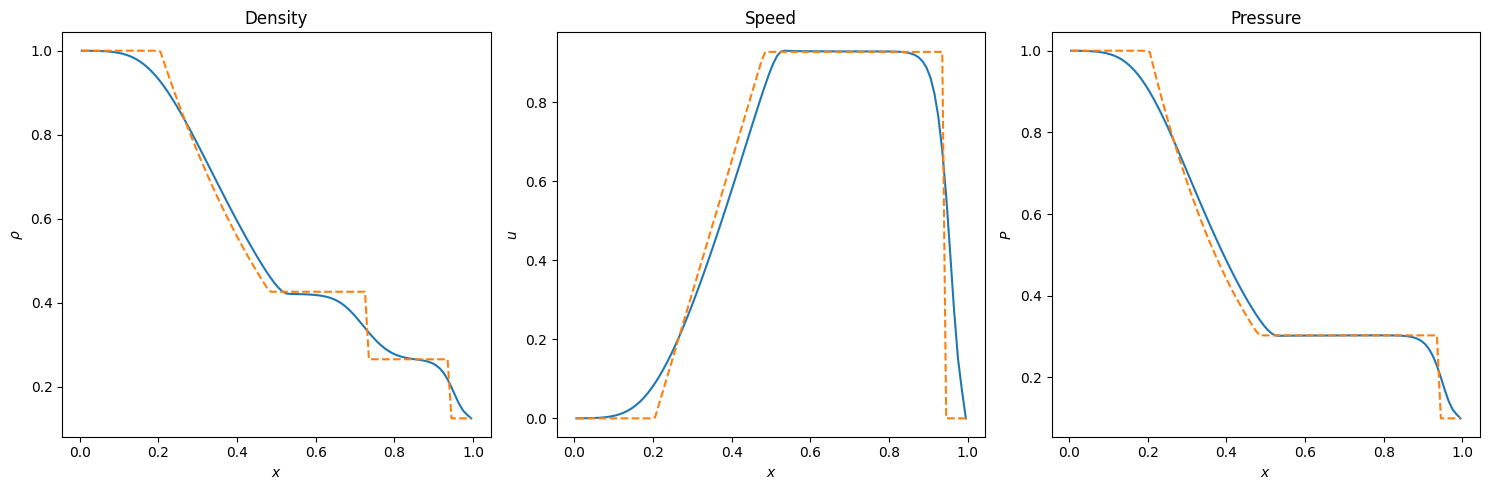

In [11]:
# RK2
grid1 = grid.grid(L=1, N=N)
grid1, init_con = problem.sod_rod_tube(grid1)
grid1.update(misc.con2prim_grid(U))
grid1.t = t_final

print(misc.calc_L1_grid(grid1, 'sod', init_con))
viz.plot_amr_value(grid1, type='sod', init_con=init_con)

0.04154975402620083


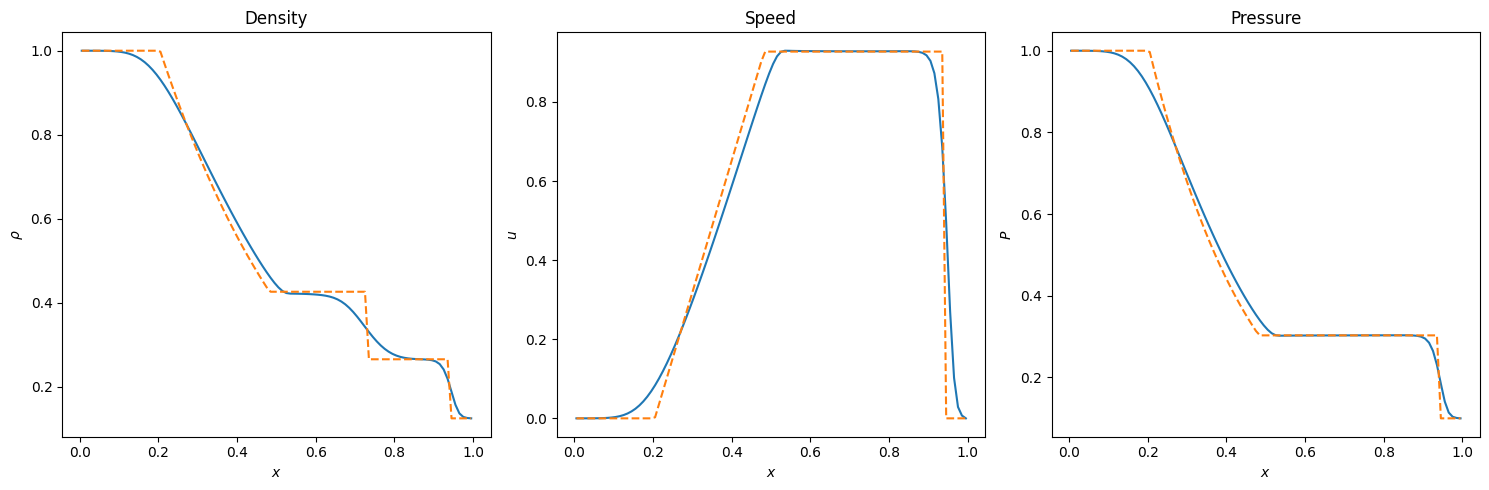

In [9]:
# RK1
grid2 = grid.grid(L=1, N=N)
grid2, init_con = problem.sod_rod_tube(grid1)
grid2.update(misc.con2prim_grid(U))
grid2.t = t_final

print(misc.calc_L1_grid(grid2, 'sod', init_con))
viz.plot_amr_value(grid2, type='sod', init_con=init_con)

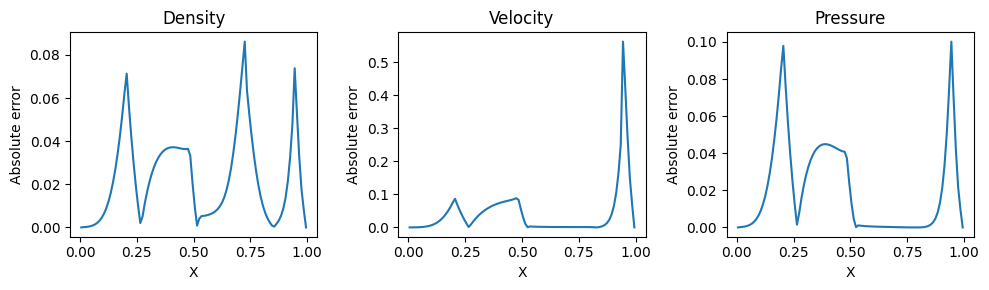

In [ ]:
grid1_error = error_graph('sod', grid1)

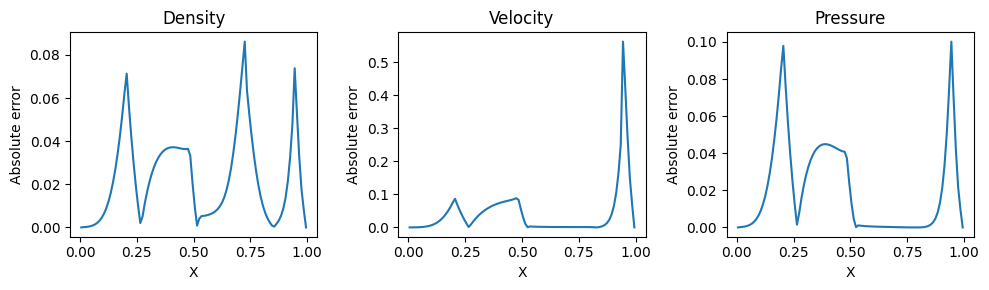

In [106]:
grid2_error = error_graph('sod', grid2)

/var/folders/f5/93qk9czs7835g6z9_k6k6wvc0000gn/T/ipykernel_25766/4083375625.py:4: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


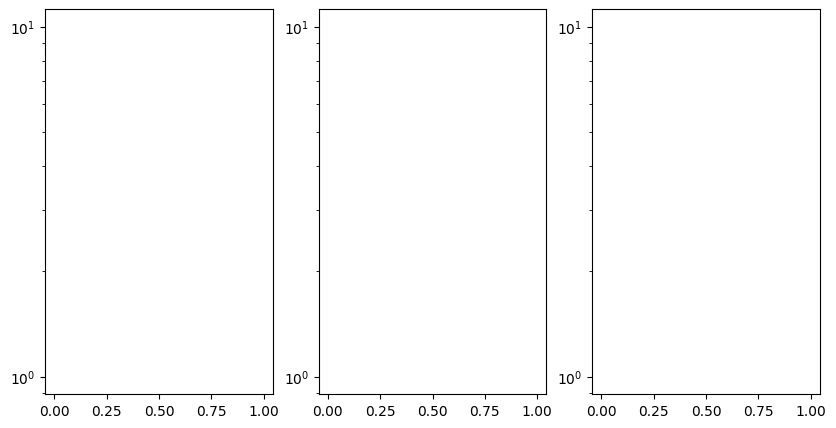

In [115]:
fig, axes = plt.subplots(1, 3, figsize=(10,5))
for a, ax in enumerate(axes):
    ax.plot(x, grid2_error[a] - grid1_error[a])
    ax.set_yscale('log')